In [1]:
import re 
from shiny import App, render, ui
from scipy.special import softmax
import numpy as np 
import shinyswatch
import requests
from bs4 import BeautifulSoup
from googleapiclient.discovery import build
import googlemaps
import tweepy
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
import spacy
import os
import google.generativeai as genai
from spacytextblob.spacytextblob import SpacyTextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from dotenv import load_dotenv
from scipy.special import softmax
import plotly.express as px

import plotly.express as px


In [85]:
load_dotenv()

True

In [86]:
url_test = 'https://es.m.wikipedia.org/wiki/Agapornis'

In [87]:
def wikipedia_content(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Lanza una excepción para códigos de error HTTP
        soup = BeautifulSoup(response.text, 'html.parser')
        paragraphs = soup.find_all('p')
        text = "\n".join([p.get_text() for p in paragraphs])
        return text[:500] + "..." if len(text) > 500 else text # Mostrar un fragmento por ahora
    except requests.exceptions.RequestException as e:
        return f"Error al acceder a Wikipedia: {e}"


In [88]:
testText = wikipedia_content(url_test)

In [89]:
import re 
test  =str('https://x.com/anabelhoficial/status/1906888988192887030')
print(re.search(r'/status/(\d+)/', test))


print(re.match(r'/status/(\d+)/', test))
print(re.match(r'.*/status/(\d+)', test).group(1))

print(re.fullmatch(r'/status/(\d+)/', test))

None
None
1906888988192887030
None


In [90]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob



In [91]:
nlp = spacy.load("es_core_news_md")
nlp.add_pipe('spacytextblob')

def generate_sentiment_analysis(text):
    doc = nlp(text)
    polarity = doc._.blob.polarity  
    sentiment='Neutral'
    if polarity > 0.1:
        sentiment = 'Positivo'
    elif polarity < -0.1:
        sentiment = 'Negativo'
    return sentiment

In [92]:
def detectEmotion(text):
  ### Obtiene el modelo preentrenado
  model_path = "daveni/twitter-xlm-roberta-emotion-es"
  tokenizer = AutoTokenizer.from_pretrained(model_path )
  config = AutoConfig.from_pretrained(model_path )
  emotions_model = AutoModelForSequenceClassification.from_pretrained(model_path)
  ### Starting the encoding
  text = str(text)
  encoded_input = tokenizer(text, return_tensors='pt')
  try:
    output = emotions_model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    emotions_score = np.sort(range(scores.shape[0]))
    emotions_score= emotions_score[0]
    l = config.id2label[ranking[emotions_score]]
    s = scores[ranking[emotions_score]]
    if l=='others':
      l='neutral'
    return l, np.round(float(s), 4)
  except:
    return None, None
  #output = emotions_model(**encoded_input)
  #return emotions_score



In [93]:
detectEmotion('Me quiero volver chango porque estoy muy estresado')

('sadness', np.float64(0.2466))

In [94]:
twitter_api_key = os.getenv('twitter_api_key')
twitter_api_secret = os.getenv('twitter_api_secret')
twitter_access_token = os.getenv('twitter_access_token')
twitter_access_token_secret = os.getenv('twitter_access_token_secret')
twitter_bearer_token = os.getenv('twitter_bearer_token')
youtube_api_key = os.getenv('YOUTUBE_API_KEY')
google_maps_api_key = os.getenv('MAPS_API_KEY')  
gemini_api_key = os.getenv('YOUTUBE_API_KEY')


In [95]:
def extract_wikipedia_paragraphs(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        paragraphs = [p.get_text() for p in soup.find_all('p')]
        return paragraphs
    except requests.exceptions.RequestException as e:
        return [f"Error al acceder a Wikipedia: {e}"]

def generate_trigrams(text):
    doc = nlp(text.lower())
    tokens = [token.text for token in doc if not token.is_punct and not token.is_space]
    trigrams = [tuple(tokens[i:i+3]) for i in range(len(tokens) - 2)]
    return trigrams



def process_wikipedia_for_df(url):
    paragraphs = extract_wikipedia_paragraphs(url)
    data = {'paragraph_number': range(1, len(paragraphs) + 1),
            'text': paragraphs,
            'length': [len(p) for p in paragraphs],
            'trigrams': [generate_trigrams(p) for p in paragraphs],
            'sentiment': [generate_sentiment_analysis(p) for p in paragraphs],
            'emotion': [detectEmotion(p)[0] for p in paragraphs]
            }
    df = pd.DataFrame(data)
    return df


# Example usage:
wikipedia_url = "https://es.wikipedia.org/wiki/Agapornis"
wikipedia_df = process_wikipedia_for_df(wikipedia_url)
print(wikipedia_df.head())
print(wikipedia_df['trigrams'].iloc[0][:5]) 

   paragraph_number                                               text  \
0                 1  Agapornis es un género de aves psitaciformes d...   
1                 2  Son loros pequeños, de cola corta y de plumaje...   
2                 3  Suelen ser animales bastante confiados con el ...   
3                 4  El género Agapornis fue introducido por Pridea...   
4                 5  Los inseparables miden de 13 a 17 cm de largo,...   

   length                                           trigrams sentiment  \
0     192  [(agapornis, es, un), (es, un, género), (un, g...   Neutral   
1     486  [(son, loros, pequeños), (loros, pequeños, de)...   Neutral   
2     224  [(suelen, ser, animales), (ser, animales, bast...   Neutral   
3     353  [(el, género, agapornis), (género, agapornis, ...   Neutral   
4     661  [(los, inseparables, miden), (inseparables, mi...  Positivo   

   emotion  
0  neutral  
1  neutral  
2  neutral  
3  neutral  
4  neutral  
[('agapornis', 'es', 'un'), ('es

In [96]:
client = tweepy.Client(bearer_token=twitter_bearer_token)
tweet_id = '1914271651962700018'


def getTweetsResponses(url):
    twitter_input = url
    #if not twitter_input  or not TWITTER_BEARER_TOKEN:
    if not twitter_input  or not twitter_bearer_token:    
        return "Error: URL de Twitter no válida o clave API no configurada."
    if "x.com/" in twitter_input and "/status/" in twitter_input:
        #match = re.search(r'/status/(\d+)/', twitter_input)
        match = re.match(r'.*/status/(\d+)', twitter_input)
        if match:
            tweet_id = match.group(1)
        else:
            return "Error: No se pudo extraer el ID del tweet."
    elif twitter_input.isdigit():
        tweet_id = twitter_input
    else: 
        return "Error: URL de Twitter no válida."   
    
    try: 
        listTweets = client.search_recent_tweets(
            query=f"conversation_id:{tweet_id}",
            expansions=["author_id"],  
            user_fields=["username"],  
            max_results=10
        )

        tweets = listTweets.data
        users = {u["id"]: u for u in listTweets.includes['users']}
        tweets_list = []
        for tweet in tweets:
            tweet_info = {
                'tweet_id': tweet.id,
                'text': tweet.text,
                'author_id': tweet.author_id,
                'username': users[tweet.author_id]["username"] if tweet.author_id in users else None,
                'created_at': tweet.created_at if hasattr(tweet, 'created_at') else None
            }
            tweets_list.append(tweet_info)
        df = pd.DataFrame(tweets_list)
        df['sentiment'] = df['text'].apply(generate_sentiment_analysis)
        df['emotion'] = df['text'].apply(lambda x: detectEmotion(x)[0])
        return pd.DataFrame(df)
    except Exception as e:
        return f"Error al obtener respuestas: {e}"


In [ ]:
#tweet_df = getTweetsResponses(tweet_id)

In [98]:
#tweet_df

In [112]:
#tweet_df.to_csv('tweets_test.csv', index=False)
tweet_df = pd.read_csv('tweets_test.csv')

In [100]:
from googleapiclient.discovery import build

In [101]:
youtube = build('youtube', 'v3', developerKey=youtube_api_key)

In [102]:
video_id_test = 'https://www.youtube.com/watch?v=NJwZ7j5qB3Y'

def get_youtube_comments(video_url):
    if "v=" in video_url:
        video_id = video_url.split("v=")[-1].split("&")[0]
    elif "youtu.be/" in video_url:
        video_id = video_url.split("youtu.be/")[-1].split("?")[0]
    #if not video_id or not YOUTUBE_API_KEY:
    if not video_id or not youtube_api_key:
        return "Error: URL de YouTube no válida o clave API no configurada."
    try:
        comments = []
        response = youtube.commentThreads().list(
            part='snippet', 
            videoId=video_id,
            textFormat='plainText',
            maxResults=10
        ).execute()
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            author = item['snippet']['topLevelComment']['snippet']['authorDisplayName']
            comments.append({'author': author, 'comment': comment})
        ### Esto será comentado, pero por ahora solo quiero los primeros 10 comentarios
        #next_page_token = None
        #while True: 
        #    response = youtube.commentThreads().list(
        #        part='snippet',
        #        videoId=video_id,
        #        textFormat='plainText',
        #        pageToken=next_page_token,
        #        maxResults=100
        #    ).execute()
        #    for item in response['items']:
        #        comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
        #        author = item['snippet']['topLevelComment']['snippet']['authorDisplayName']
        #        comments.append({'author': author, 'comment': comment})
        #    next_page_token = response.get('nextPageToken')
        #    if not next_page_token:
        #        break
        df = pd.DataFrame(comments)
        df['sentiment'] = df['comment'].apply(generate_sentiment_analysis)
        df['emotion'] = df['comment'].apply(lambda x: detectEmotion(x)[0])
        return df
    except Exception as e:
        return f"Error al obtener comentarios: {e}"



In [103]:
yotube_df = get_youtube_comments(video_id_test)

In [105]:
yotube_df.shape

(10, 4)

In [106]:
yotube_df.head()

,author,comment,sentiment,emotion
0,@mysterycroman,Que los veganos den gracia de que las hormigas...,Neutral,anger
1,@DoriaOlmedoespinoza,la quinta gerra de LAS HORMIGAS,Neutral,neutral
2,@ldguns7114,Una mosca largaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...,Neutral,neutral
3,@Ikersauriorex,Estos videos me encantan,Neutral,joy
4,@ldguns7114,Es una mosca hurraaa!,Neutral,anger


In [107]:
place_test = 'Museo Nacional de Antropología, Ciudad de México'
def mapsComments(placename):
    if not placename or not google_maps_api_key:
        return 'Falta el nombre del lugar o no hay una clave válida'
    try:
        comments = []
        gmaps = googlemaps.Client(google_maps_api_key)
        find_place_result = gmaps.find_place(placename, input_type='textquery')
        if find_place_result['status']=='OK':
            place_id = find_place_result['candidates'][0]['place_id']
            place_details = gmaps.place(place_id, fields = ['name', 'rating', 'review', 'formatted_address'], language='es')
            reviews = place_details['result'].get('reviews', [])
            while 'next_page_token' in place_details['result']:
                time.sleep(2)
                place_details = gmaps.place(place_id, fields=['name', 'rating', 'review', 'formatted_address'], 
                                            page_token=place_details['result']['next_page_token'],  language='es')
                reviews.extend(place_details['result'].get('reviews', []))
            for review in reviews:
                comments.append({'author': review['author_name'], 'comment': review['text'], 'rating': review['rating']})
        df = pd.DataFrame(comments)
        df['sentiment'] = df['comment'].apply(generate_sentiment_analysis)
        df['emotion'] = df['comment'].apply(lambda x: detectEmotion(x)[0])
        return df
    except Exception as e: 
        return f"Error al obtener comentarios: {e}"

In [108]:
googlemaps_df = mapsComments(place_test)

In [109]:
googlemaps_df.head()

,author,comment,rating,sentiment,emotion
0,Eder Calderón,El museo sufrió un robo muy famoso en el año d...,5,Neutral,neutral
1,Alejandra Garcia,definitivamente requiere varias horas. Hay tan...,5,Positivo,joy
2,J0B 00,Imperdible e impresionante. Podría calificar c...,5,Neutral,joy
3,Krystel Deyanira Cruz Baac,"Es un museo muy grande y muy bonito, buenas ex...",5,Neutral,neutral
4,Alejandra Cázares,"Excelente museo, bastante amplio. Se recorre m...",5,Neutral,joy


In [115]:
def plot_sentiment_distribution(df):
    sentiment_categories = ['Positivo', 'Neutral', 'Negativo']
    df['sentiment'] = pd.Categorical(df['sentiment'], categories=sentiment_categories, ordered=True)
    colors = {
        'Positivo': '#0d9a66',  # Verde
        'Neutral': '#ffe599',   # Amarillou XD
        'Negativo': '#ff585d'   # Rojo
    }
    grouped_df = df.groupby('sentiment').size().reset_index(name='counts')
    color_list = [colors[cat] for cat in grouped_df['sentiment']]
    barplot = px.bar(grouped_df, x='sentiment', y='counts', title='Sentiment Analysis of the paragraphs', color='sentiment', 
                     color_discrete_sequence=color_list, category_orders={'sentiment': sentiment_categories}).show()
    return barplot

In [120]:
def plot_emotion_distribution(df):
    grouped_df= df.groupby('emotion').size().reset_index(name='counts')
    barplot = px.bar(grouped_df, x='emotion', y='counts', title='Emotion Analysis of the paragraphs', color='emotion').show()
    return barplot    

In [116]:
plot_sentiment_distribution(wikipedia_df)

E:\Users\1167486\AppData\Local\Temp\ipykernel_4056\506747544.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [121]:
plot_emotion_distribution(wikipedia_df)

In [118]:
plot_sentiment_distribution(tweet_df)

E:\Users\1167486\AppData\Local\Temp\ipykernel_4056\506747544.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [122]:
plot_emotion_distribution(tweet_df)

In [123]:
plot_sentiment_distribution(yotube_df)

E:\Users\1167486\AppData\Local\Temp\ipykernel_4056\506747544.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [124]:
plot_emotion_distribution(yotube_df)

In [126]:
plot_sentiment_distribution(googlemaps_df)

E:\Users\1167486\AppData\Local\Temp\ipykernel_4056\506747544.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [125]:
plot_emotion_distribution(googlemaps_df)

#### Ahora a colapsar el texto y generar el resumen

In [ ]:
def collapse_text(df):
    try: 
        if 'text' in df.columns: 
            total_text = df['text']
            joined_text = " ".join(total_text)
            return joined_text
        elif 'comment' in df.columns:
            total_text = df['comment']
            joined_text = " ".join(total_text)
            return joined_text
        else:
            return None   
    except Exception as e:
        return f"Error al intentar unir el texto: {e}" 

In [ ]:
def summary_generator(text):   
    print('Entrando a la función de resumen')
    summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
    if text:
        try:
            text = str(text)
            print('Comenzando a resumir')
            summary = summarizer(text, max_length=150, min_length=30, do_sample=False)[0]['summary_text']
            print('Terminó de resumir')
            return f"Resumen: \n{summary}"
        except Exception as e: 
            return f"Error al resumir: {e}"
    else:
        return "No hay texto para resumir."


In [150]:
def summary_output(df):
    text_to_summarize = collapse_text(df)
    return summary_generator(text_to_summarize)

In [153]:
summary_output(googlemaps_df)

Entrando a la función de resumen


Device set to use cpu


Comenzando a resumir
Terminó de resumir


'Resumen:\nChapultepec is un espacio cultural espectacular para los ojos que lo miren, nacionales or extranjeros. El museo sufrió un robo muy famoso en el año of 1985, posterior a eso se invirtieron millones of pesos in circuito cerrado. El ingreso a mexicanos es gratis.'

In [9]:
def sentiment_output(input_text):
    nlp_sentiment = None
    try: 
        nlp_sentiment = spacy.load("es_core_news_md")
        nlp_sentiment.add_pipe('spacytextblob')
    except Exception as e:  
        print(f"Error al cargar el modelo de Spacy: {e}")
        return ui.output_text("sentiment_error", f"Error al cargar el modelo de Spacy: {e}")
    all_text_to_analyze ={
        #"Comentarios de YouTube": input.youtube_comments(),
        #"Comentarios de Google Maps": input.maps_comments(),
        #"Posts de Twitter": input.twitter_posts(),
        "Texto de Wikipedia": input_text            
    }
    print(f"Texto a analizar en sentimientos: {all_text_to_analyze}")
    sentiment_data = []
    for source, text in all_text_to_analyze.items():
        if text and not text.startswith("Error"):
            try:
                doc = nlp_sentiment(text)
                polarity = doc._.blob.polarity  
                sentiment='Neutral'
                if polarity > 0.1:
                    sentiment = 'Positivo'
                elif polarity < -0.1:
                    sentiment = 'Negativo'
                sentiment_data.append({"Source": source, "Sentiment": sentiment})
            except Exception as e:
                print(f"Error analyzing sentiment for {source}: {e}")
        else:
            print(f"No text available for sentiment analysis for {source}")
    if not sentiment_data:
        return ui.output_text("No hay texto para analizar.")
        
    df_sentiment= pd.DataFrame(sentiment_data)
    sentiment_counts= df_sentiment.groupby('Source')['Sentiment'].value_counts(normalize=True).unstack().fillna(0)
    fig, ax = plt.subplots(figsize=(10, 6))
    sentiment_counts.plot(kind='bar', stacked=True, ax=ax)
    plt.title('Distribución de Sentimientos')
    plt.xlabel("Source")
    plt.ylabel("Percentage")
    plt.xticks(rotation=45, ha="right")

    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height:.1%}', (x + width/2, y + height/2), ha='center', va='center')

    plt.tight_layout()
    return fig


Texto a analizar en sentimientos: {'Texto de Wikipedia': 'Agapornis es un género de aves psitaciformes de la familia Psittacidae, cuyos miembros son nativos de África, y son conocidos comúnmente como inseparables, periquitos de amor o aves del amor.\n\nSon loros pequeños, de cola corta y de plumaje muy colorido. El tamaño de las nueve especies está comprendido entre 13 y 16\xa0cm. Se alimentan de semillas, frutas y yemas. Tienen una vida media entre diez y doce años (aunque no es difícil que en cautividad y con unos cuidados adecuados puedan llegar a vivir ...'}


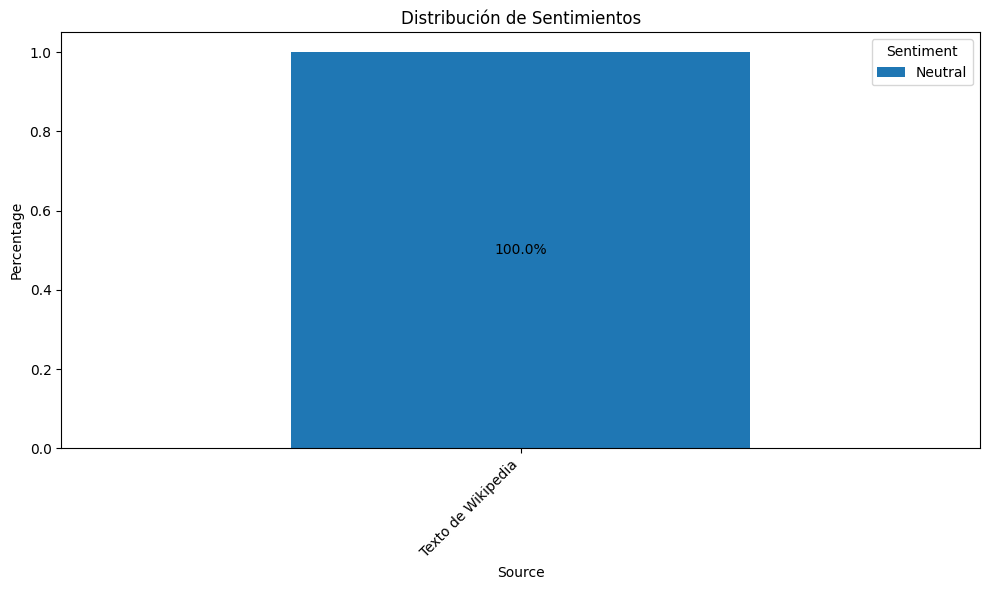

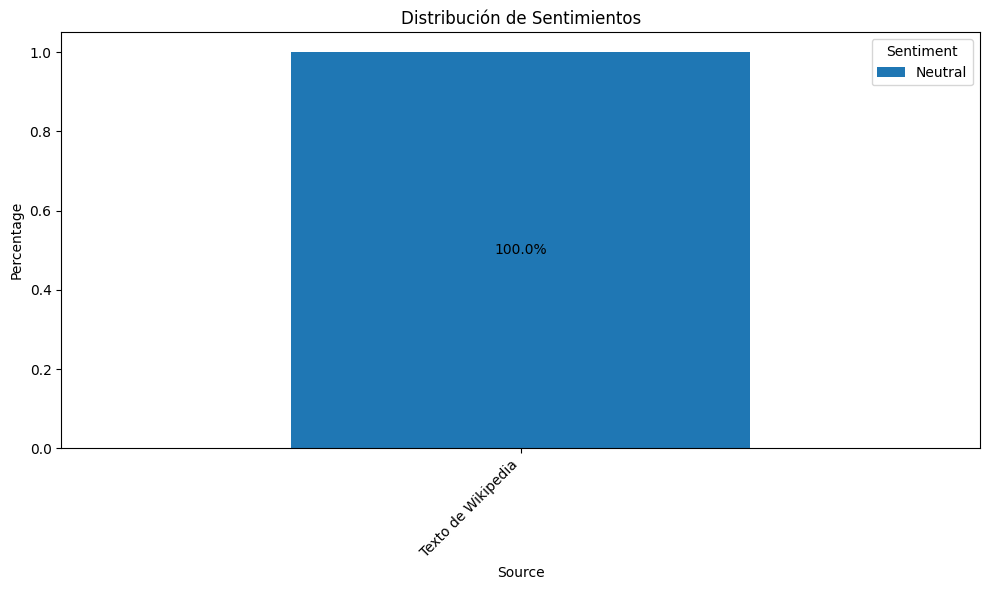

In [10]:
sentiment_output(testText)

In [15]:
def summary_output(input):
    summarizer = pipeline("summarization", model = "facebook/bart-large-cnn")
    #summarizer = pipeline("summarization", model = "ELiRF/mt5-base-dacsa-es")
    summary = summarizer(input, max_length=150, min_length=30, do_sample=False)[0]['summary_text']
    return f"Resumen:\n{summary}"
'''
def summary_output():
        summarizer = pipeline("summarization", model = "facebook/bart-large-cnn")
        #summarizer = pipeline("summarization", model="ELiRF/mt5-base-dacsa-es")
        all_text_to_summarize = ""
        wikipedia_text = input.wikipedia_content()
        print(f"Contenido wikipedia:\n{wikipedia_text[:200]}") 
        youtube_info_text = input.youtube_info()
        print(f"Contenido youtube:\n{youtube_info_text[:200]}")        
        maps_info_text = input.maps_info()
        print(f"Contenido maps:\n{maps_info_text[:200]}")
        twitter_posts_text = input.twitter_posts()
        print(f"Contenido twitter:\n{twitter_posts_text[:200]}")    
        if wikipedia_text and not wikipedia_text.startswith("Error"):
            all_text_to_summarize += wikipedia_text + '\n\n'
        if youtube_info_text and not youtube_info_text.startswith("Error"):
            all_text_to_summarize += youtube_info_text + '\n\n'
        if maps_info_text and not maps_info_text.startswith("Error"):
            all_text_to_summarize += maps_info_text + '\n\n'
        if twitter_posts_text and not twitter_posts_text.startswith("Error"):
            all_text_to_summarize += twitter_posts_text + '\n\n'

        print(f"Texto a resumir:\n{all_text_to_summarize}")
        if all_text_to_summarize:
            try: 
                summary = summarizer(all_text_to_summarize, max_length=150, min_length=30, do_sample=False)[0]['summary_text']
                return f"Resumen:\n{summary}"
            except Exception as e:
                return f"Error al resumir: {e}"
        else:
            return "No hay texto para resumir."
'''    


'\ndef summary_output():\n        summarizer = pipeline("summarization", model = "facebook/bart-large-cnn")\n        #summarizer = pipeline("summarization", model="ELiRF/mt5-base-dacsa-es")\n        all_text_to_summarize = ""\n        wikipedia_text = input.wikipedia_content()\n        print(f"Contenido wikipedia:\n{wikipedia_text[:200]}") \n        youtube_info_text = input.youtube_info()\n        print(f"Contenido youtube:\n{youtube_info_text[:200]}")        \n        maps_info_text = input.maps_info()\n        print(f"Contenido maps:\n{maps_info_text[:200]}")\n        twitter_posts_text = input.twitter_posts()\n        print(f"Contenido twitter:\n{twitter_posts_text[:200]}")    \n        if wikipedia_text and not wikipedia_text.startswith("Error"):\n            all_text_to_summarize += wikipedia_text + \'\n\n\'\n        if youtube_info_text and not youtube_info_text.startswith("Error"):\n            all_text_to_summarize += youtube_info_text + \'\n\n\'\n        if maps_info_text and

In [16]:
summary_output(testText)

Device set to use cpu


'Resumen:\nAgapornis es un género de aves psitaciformes de la familia Psittacidae, cuyos miembros son nativos de África. Son loros pequeños, de cola corta y de plumaje muy colorido. Se alimentan de semillas, frutas y yemas.'

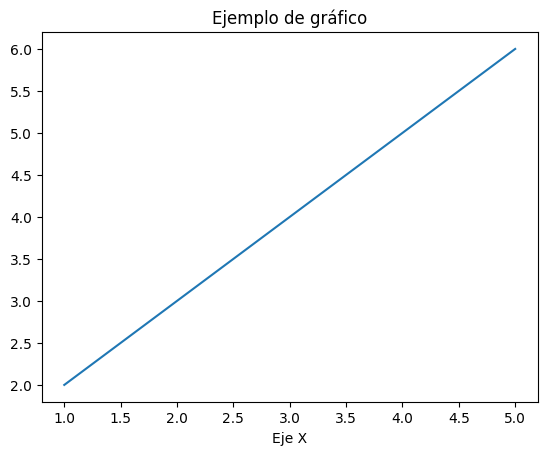

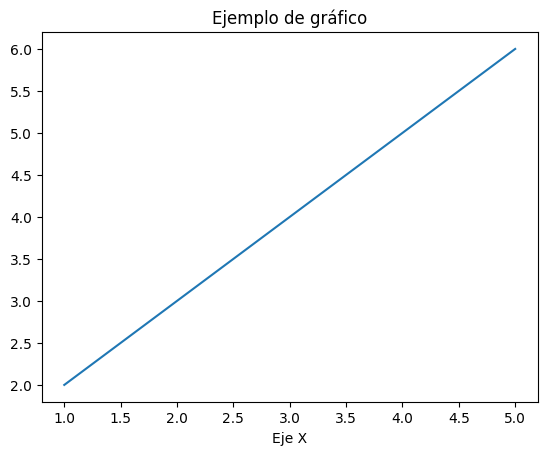

In [19]:
def sentiment_output():
    x= [1,2,3,4,5]
    y= [2,3,4,5,6]
    fig, ax = plt.subplots()
    ax.plot(x,y)
    ax.set_title("Ejemplo de gráfico")
    ax.set_xlabel("Eje X")
    return fig
sentiment_output()

Text(0.5, 0, 'Eje X')

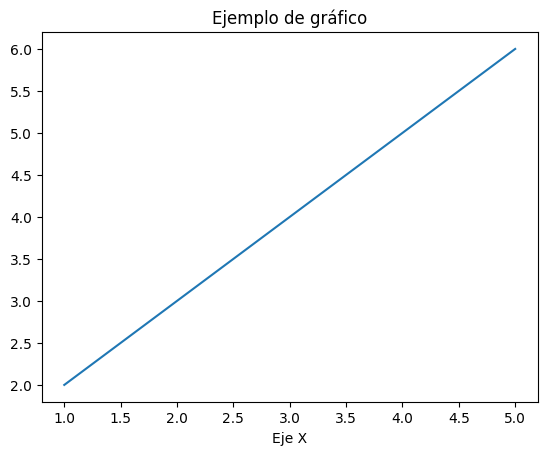

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
x= [1,2,3,4,5]
y= [2,3,4,5,6]
plt.plot(x,y)
plt.title("Ejemplo de gráfico")
plt.xlabel("Eje X")